In [2]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!pip install lightkurve

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0
  libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb
  poppler-data preview-latex-style rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils tex-common
  tex-gyre texlive-base texlive-binaries texlive-fonts-recommended
  texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-framework-java l

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lc
from google.colab import drive
drive.mount('/content/drive')
from scipy.fft import fft, fftfreq
from tqdm import tqdm
plt.rcParams['text.usetex'] = True

/usr/local/lib/python3.11/dist-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


Mounted at /content/drive


In [4]:
y = np.load("/content/drive/MyDrive/lumiere physics research - sampurna/python code/detrended_lc.npy")
time = np.load("/content/drive/MyDrive/lumiere physics research - sampurna/python code/time.npy")

In [5]:
# fft:
fourier = fft(y)
sampling_interval = time[1] - time[0]
freq = fftfreq(len(time), d=sampling_interval)

# mask to get positive (non-zero) frequencies
mask = freq > 0
freq = freq[mask]
fourier = fourier[mask]

# period and power
periods = 1 / freq
power = np.abs(fourier)**2

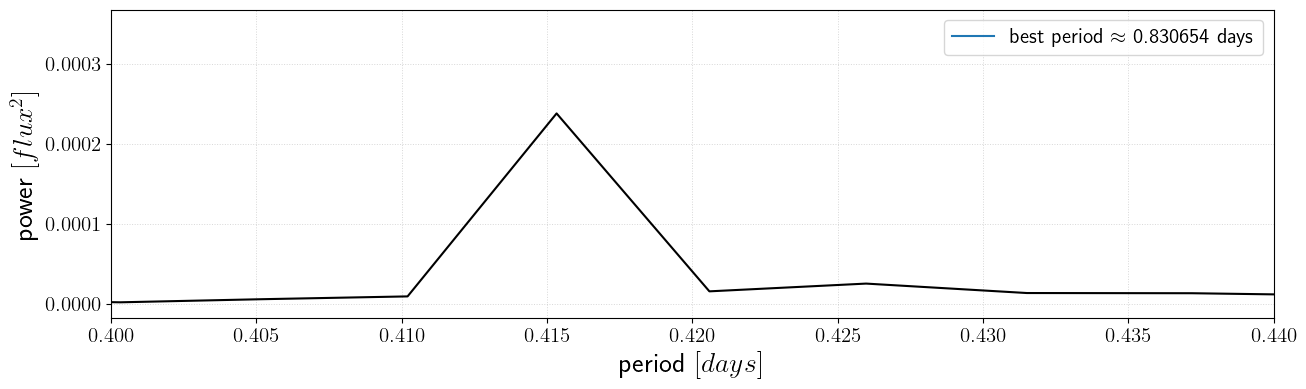

In [6]:
plt.figure(figsize=(15, 4))
plt.plot(periods, power, color='black')
plt.xlim(0.40, 0.44)
best_period = periods[np.argmax(power)]
plt.axvline(best_period, label=rf'best period $\approx$ {best_period:.6f} days')
plt.xlabel(r"period $[days]$", fontsize=20)
plt.ylabel(r"power $[flux^2]$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True, linestyle=':', linewidth=0.7, alpha=0.5)
plt.legend(fontsize=15)


plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig("/content/drive/MyDrive/lumiere physics research - sampurna/python code/bestperiod.png", dpi=600, bbox_inches="tight")

plt.show()

In [7]:
# folding
epoch_time = time[np.argmin(y)]
lc_object = lc.LightCurve(time=time, flux=y)

/tmp/ipython-input-8-3579533046.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


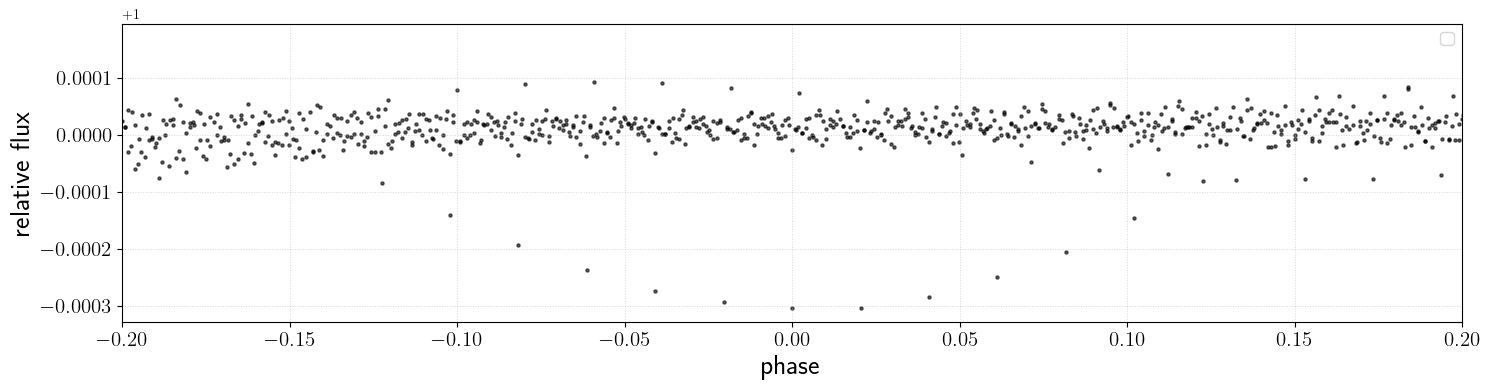

In [8]:
best_period = 0.830654
folded = lc_object.fold(period=best_period, epoch_time=epoch_time)

folded_lc = folded.flux.value
phase = folded.time.value

shift = phase[np.argmin(folded_lc)]
phase = phase - shift

plt.figure(figsize=(15, 4))
plt.scatter(phase, folded_lc, color='black', s=5, alpha=0.6)

plt.xlabel(r"phase", fontsize=20)
plt.ylabel(r"relative flux", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlim(-0.2, 0.2)
plt.grid(True, linestyle=':', linewidth=0.7, alpha=0.5)

plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig("/content/drive/MyDrive/lumiere physics research - sampurna/python code/phasefolded.png", dpi=600, bbox_inches="tight")

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [9]:
y = folded.flux.value
x = folded.time.value
x_val = x < 0
mean_left = y[x_val].mean()
mean_right = y[~x_val].mean()

print(mean_left/mean_right)

0.9999854493807478


In [10]:
print(len(folded.time.value))
print(len(folded.flux.value))

1626
1626


In [11]:
q = 0.25
d = 0.0003

In [12]:
out_of_transit = (np.abs(phase) > 0.05)
baseline = np.median(folded_lc[out_of_transit])
flux = folded_lc / baseline

def box_model (phase, d, q, center):
  box_fit = np.ones_like(phase)
  mask = (phase >= center - q/2) & (phase <= center + q/2)
  box_fit[mask] -= d
  return box_fit

In [13]:
print(phase.max(), phase.min())

0.4148237585225535 -0.4149668026822869


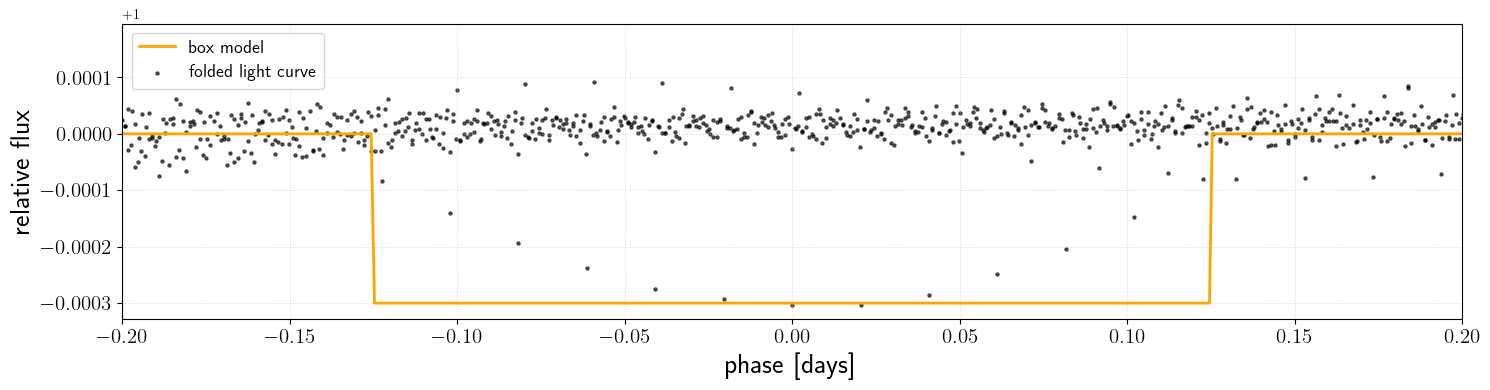

In [14]:
plt.figure(figsize=(15, 4))

box_fit = box_model(phase, d, q, center=0)  # Assuming initial center ≈ 0

plt.plot(phase, box_fit, color='orange', lw=2, label='box model')
plt.scatter(phase, folded_lc, color='black', s=5, alpha=0.6, label='folded light curve')

plt.xlim(-0.2, 0.2)
plt.xlabel(r"phase [days]", fontsize=20)
plt.ylabel(r"relative flux", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.grid(True, linestyle=':', linewidth=0.7, alpha=0.5)
plt.legend(fontsize=13)
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/lumiere physics research - sampurna/python code/boxfitted.png", dpi=600, bbox_inches="tight")

plt.show()

In [15]:
def chi_squared(y_obs, y_exp):
    return np.sum((y_obs - y_exp)**2/y_exp)

In [16]:
"""Function Logic"""
# define func that takes in lower and upper boundaries

# create the q and d arrays

# create chi2 array of shape (len(q), len(d))
# for every value in q
#    for every value in d
#        pair them up (q, d)
#        compute the model fit
#        compute the chi2
#        save the chi2 in the chi2 array
#  end for
#
# compute the argument of the mininum chi2
# find the argument in q_arr and d_arr
# return q_best, d_best

def grid_search(q_bounds, d_bounds, center_bounds):
    # define the grid
    q_arr = np.linspace(*q_bounds, 50)
    d_arr = np.linspace(0.00015, 0.00025, 200)
    center_arr = np.linspace(*center_bounds, 50)
    # np.linspace --> np.geomspace

    chi2_arr = np.ones(shape=(len(q_arr), len(d_arr), len(center_arr)))
    for i, q in enumerate(tqdm(q_arr)):
        for j, d in enumerate(d_arr):
          for k, center in enumerate(center_arr):
            box_fit = box_model(phase, d, q, center)
            chi2 = chi_squared(y_obs=flux, y_exp=box_fit)
            chi2_arr[i, j, k] = chi2

    argmin = chi2_arr.argmin()
    i_best, j_best, k_best = np.unravel_index(argmin, chi2_arr.shape)

    return q_arr[i_best], d_arr[j_best],  center_arr[k_best], chi2_arr

In [17]:
q_bounds = (0.01, 0.1)
d_bounds = (0.0001, 0.003)
center_bounds = (-0.02, 0.02)
q_best, d_best, center_best, chi2_arr = grid_search(q_bounds, d_bounds, center_bounds)

100%|██████████| 50/50 [00:15<00:00,  3.24it/s]


In [18]:
chi2_arr.shape

(50, 200, 50)

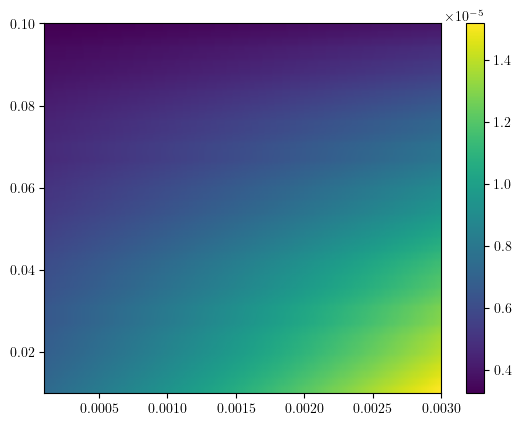

In [19]:
plt.imshow(chi2_arr[:,:,25], aspect='auto', extent=(d_bounds[0], d_bounds[-1], q_bounds[0], q_bounds[-1]), cmap='viridis') # range for all the computed chi-squared values
plt.colorbar()
plt.show()

In [20]:
print(q_best, d_best, center_best)

0.01 0.00015 0.019183673469387753


/tmp/ipython-input-21-4246730513.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(phase_shifted, best_fit, 'k-', lw=2, label='box fit', color='orange')


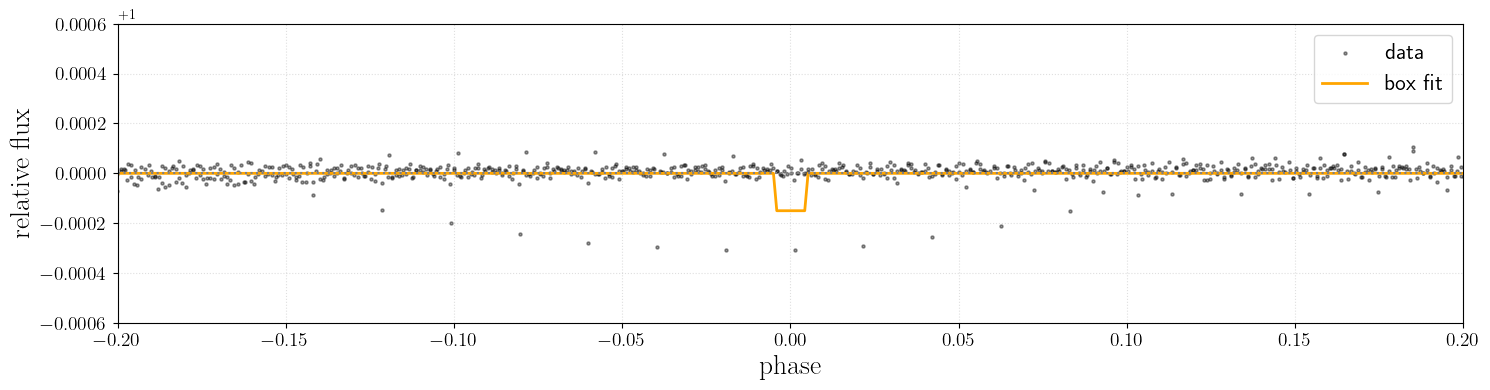

In [21]:
phase_shifted = phase - center_best
best_fit = box_model(phase_shifted, d_best, q_best, center=0)

fig, ax = plt.subplots(figsize=(15, 4))

ax.scatter(phase_shifted, flux, s=5, alpha=0.4, color='black', label='data')
ax.plot(phase_shifted, best_fit, 'k-', lw=2, label='box fit', color='orange')
ax.axhline(1, ls=':', color='gray')

ax.set_xlim(-0.2, 0.2)
ax.set_ylim(1 - 6e-4, 1 + 6e-4)
ax.set_xlabel(r"\rm phase", fontsize=20)  # TODO: phase not measured in days!
ax.set_ylabel(r"\rm relative flux", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=16)
ax.grid(True, ls=':', alpha=0.4)

plt.savefig("/content/drive/MyDrive/lumiere physics research - sampurna/python code/final", dpi=600, bbox_inches="tight")

plt.tight_layout()
plt.show()

In [22]:
d_best = d_best
d_values = np.linspace(0.5 * d_best, 1.5 * d_best, 150)

chi2_vals = []

for d in d_values:
    model = box_model(phase_shifted, d=d, q=q_best, center=0)
    chi2 = chi_squared(y_obs=flux, y_exp=model)
    chi2_vals.append(chi2)

chi2_vals = np.array(chi2_vals)

chi2_min = np.min(chi2_vals)
threshold = chi2_min + 1  # 1-sigma for 1 parameter

In [23]:
mask = chi2_vals <= threshold
left = d_values[(d_values < d_best) & mask]
right = d_values[(d_values > d_best) & mask]

if len(left) > 0 and len(right) > 0:
    d_lower = left[-1]
    d_upper = right[0]
    sigma_d = 0.5 * (d_upper - d_lower)
    print(f"sigma_d = {sigma_d:.8f}")

sigma_d = 0.00000050


In [24]:
delta = d_best  # best-fit depth
rp_over_rs = np.sqrt(d_best)
print(f"Rp/Rs = {rp_over_rs:.6f}")

Rp/Rs = 0.012247


In [25]:
sigma_delta = sigma_d  # chi2-based uncertainty
sigma_rp_over_rs = 0.5 * sigma_delta / np.sqrt(delta) # general error propagation formula
print(f"Rp/Rs = {rp_over_rs:.5f} ± {sigma_rp_over_rs:.5f}")

Rp/Rs = 0.01225 ± 0.00002
